# DATA 612 Project 2

*   Farhod Ibragimov
*   Gillian McGovern

### Introduction

This project delves into the construction of a movie recommendation system, starting from fundamental techniques and progressing to more sophisticated methods. We begin with a content-based approach, which recommends movies based on their intrinsic properties like genre and title. Subsequently, we explore collaborative filtering, a method that leverages user ratings and behavior to generate recommendations.

The primary objectives are:

1. To build and compare simple content-based recommenders using TF-IDF with Cosine Similarity and Jaccard Similarity.
2. To enhance our dataset by integrating detailed movie information from The Movie Database (TMDb), thereby creating a more refined content-based model.
3. To implement both user-based and item-based collaborative filtering, utilizing user ratings to predict potential movie preferences.
4. To quantitatively assess our collaborative filtering model's performance using Root Mean Squared Error (RMSE).

Let's begin.

In [ ]:
import pandas as pd
import numpy as np
# !pip install tmdbsimple
import tmdbsimple as tmdb
import os
import time
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from typing import Set, Union
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

### Part 1: Content-Based Filtering

The most intuitive approach to building a recommendation system is content-based filtering. The underlying principle is straightforward: if a user likes a particular item, they are also likely to appreciate items that are similar to it. Our initial task is to define "similarity" based on the available data, which, in this case, consists of movie titles and genres.

### Data Loading and Preprocessing

We start by loading the MovieLens 100k dataset, which provides us with a list of movies and their corresponding genres, as well as user ratings. For our content-based models, we'll initially focus on the movies dataframe.

The genres are presented in a one-hot encoded format. To facilitate text-based similarity analysis, we convert these genre columns into a single, space-separated string for each movie. For instance, a film categorized as **Animation, Children's, and Comedy** will be represented by the string **"Animation Children's Comedy"**.

In [ ]:
ratings = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u.data",
    sep="\t", names=["user_id", "movie_id", "rating", "timestamp"]
)

movie_cols = ["movie_id", "title", "release_date", "video_release_date", "IMDb_URL"] + \
             ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
              "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
              "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
genre_cols = movie_cols[5:]

movies = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u.item",
    sep="|", names=movie_cols, encoding="latin-1"
)[["movie_id", "title"] + genre_cols]

display(movies.head())
display(ratings.head())

,movie_id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Model 1: TF-IDF and Cosine Similarity
To quantify the similarity between text-based descriptions, we employ the Term Frequency-Inverse Document Frequency (TF-IDF) vectorization technique in conjunction with Cosine Similarity.

**TF-IDF**: This method transforms our textual data—a combination of the movie title and its genre string—into a numerical feature matrix. It assigns higher weights to terms that are significant to a specific movie's description but are less common across the entire dataset.

In [ ]:
def genres_to_string(row):
    return ' '.join([genre for genre in genre_cols if row[genre] == 1])

movies["genre_str"] = movies[genre_cols].apply(genres_to_string, axis=1)

movies[['title', 'genre_str']].head()


,title,genre_str
0,Toy Story (1995),Animation Children's Comedy
1,GoldenEye (1995),Action Adventure Thriller
2,Four Rooms (1995),Thriller
3,Get Shorty (1995),Action Comedy Drama
4,Copycat (1995),Crime Drama Thriller


## What is cosine similarity?
Cosine Similarity
Cosine Similarity is a metric used to measure the similarity between two non-zero vectors in an inner product space. It calculates the cosine of the angle between them. When used in text analysis, it helps determine how similar two documents are, regardless of their size.

A cosine value of 0 indicates that the two vectors are orthogonal (not similar at all), a value of 1 indicates that the vectors are identical, and a value of -1 indicates the vectors are diametrically opposite. For text data that has been converted into numerical vectors (like with TF-IDF), cosine similarity is a very effective way to measure content similarity.

The formula for Cosine Similarity between two vectors, A and B, is:

$$
\text{similarity} = \cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}
$$


Where:

* $\mathbf{A}$
  and $\mathbf{B}$
  are the components of vectors A and B, respectively.

* ${\mathbf{A} \cdot \mathbf{B}}$ is the dot product of the two vectors.

* $\|\mathbf{A}\|$ and $\|\mathbf{B}\|$ are the magnitudes (or Euclidean norms) of the vectors.

 **Cosine Similarity**: With the TF-IDF matrix, we can compute a similarity score between every pair of movies. This metric calculates the cosine of the angle between two vectors; a score of 1 indicates identical movies, while 0 signifies no commonality.

In [ ]:

movies["pseudo_plot"] = movies["title"] + " " + movies["genre_str"]

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movies["pseudo_plot"])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

title_to_index = pd.Series(movies.index, index=movies["title"])

def recommend_by_cosine(title, top_n=5):
    try:
        idx = title_to_index[title]
    except KeyError:
        display(f"Error: Movie '{title}' not found in the dataset.")
        return None

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    top_recommendations = sim_scores[1:top_n+1]

    movie_indices = [i[0] for i in top_recommendations]
    similarity_scores = [i[1] for i in top_recommendations]

    recommendations_df = movies.iloc[movie_indices].copy()
    recommendations_df['similarity'] = similarity_scores

    return recommendations_df[["title", "genre_str", "similarity"]]



## Model 2: Jaccard Similarity
As an alternative, we use the Jaccard Similarity index, which operates on sets of items rather than numerical vectors. It is calculated as the size of the intersection divided by the size of the union of two sets. For our purposes, each movie's "set" comprises the individual words in its title and its associated genres.

**Jaccard Similarity**

Jaccard Similarity (also known as the Jaccard Index) is a statistic used for gauging the similarity and diversity of finite sample sets. It's defined as the size of the intersection divided by the size of the union of the two sets.

This metric is particularly useful for comparing sets of items where the order and frequency do not matter, such as the set of words in a movie title or the set of genres associated with it. A score of 1 means the sets are identical, and a score of 0 means they have no elements in common.

The formula for Jaccard Similarity between two sets, A and B, is:
$$
J(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$

Where:
* $|A \cap B|$ is the number of elements common to both set A and set B.
* $|A \cup B|$ is the total number of unique elements across both sets.

In [ ]:
def create_token_set(row):
    genres = {genre for genre in genre_cols if row[genre] == 1}
    title_words = set(row['title'].lower().split(' (')[0].split())
    return genres.union(title_words)

movies['tokens'] = movies.apply(create_token_set, axis=1)

def recommend_by_jaccard(title, top_n=5):
    try:
        target_tokens = movies.loc[movies['title'] == title, 'tokens'].iloc[0]
    except IndexError:
        display(f"Error: Movie '{title}' not found in the dataset.")
        return None

    sim_scores = []
    for index, row in movies.iterrows():
        intersection = len(target_tokens.intersection(row['tokens']))
        union = len(target_tokens.union(row['tokens']))
        score = intersection / union if union > 0 else 0
        sim_scores.append((index, score))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    top_recommendations = sim_scores[1:top_n+1]

    movie_indices = [i[0] for i in top_recommendations]
    similarity_scores = [i[1] for i in top_recommendations]

    recommendations_df = movies.iloc[movie_indices].copy()
    recommendations_df['similarity'] = similarity_scores

    return recommendations_df[["title", "genre_str", "similarity"]]



## Testing models (title + genre)

In [ ]:
display("--- Testing 'Toy Story (1995)' ---")
display("[Cosine Similarity Recommendations]")
display(recommend_by_cosine("Toy Story (1995)"))
display("[Jaccard Similarity Recommendations]")
display(recommend_by_jaccard("Toy Story (1995)"))

"--- Testing 'Toy Story (1995)' ---"

'[Cosine Similarity Recommendations]'

,title,genre_str,similarity
1071,"Pyromaniac's Love Story, A (1995)",Comedy Romance,0.352262
1065,Balto (1995),Animation Children's,0.345902
1218,"Goofy Movie, A (1995)",Animation Children's Comedy Romance,0.313701
547,"NeverEnding Story III, The (1994)",Children's Fantasy,0.310664
541,Pocahontas (1995),Animation Children's Musical Romance,0.306716


'[Jaccard Similarity Recommendations]'

,title,genre_str,similarity
94,Aladdin (1992),Animation Children's Comedy Musical,0.428571
992,Hercules (1997),Adventure Animation Children's Comedy Musical,0.375000
242,Jungle2Jungle (1997),Children's Comedy,0.333333
376,Heavyweights (1994),Children's Comedy,0.333333
403,Pinocchio (1940),Animation Children's,0.333333


## Initial Results and Analysis
Upon testing both models with "Toy Story (1995)," we observe distinct outcomes:

**Cosine Similarity Recommendations**: This model appears to be influenced by the word "Story," recommending titles such as "A Pyromaniac's Love Story" and "The NeverEnding Story III."

**Jaccard Similarity Recommendations**: This model leans more heavily on genre overlap, suggesting classic animated comedies like "Aladdin," "Hercules," and "Pinocchio."

**Critique and Further Thought**: The disparity in these results underscores a fundamental question in recommendation systems: should the system prioritize novelty and variety, or should it adhere strictly to thematic consistency? The influence of the word "Story" in the cosine similarity results also suggests that feature selection and weighting are critical for refining a model's performance.

## Cosine and Jaccard similarity models (genres only):
**Genre-Only Similarity Models**:
To mitigate the noise introduced by movie titles, we adapt our functions to consider only genres.

In [ ]:
vectorizer_genre = TfidfVectorizer()
tfidf_matrix_genre = vectorizer_genre.fit_transform(movies["genre_str"])
cosine_sim_genre = linear_kernel(tfidf_matrix_genre, tfidf_matrix_genre)

def recommend_by_cosine_genre_only(title: str, top_n: int = 5) -> Union[pd.DataFrame, None]:
    try:
        idx = title_to_index[title]
    except KeyError:
        display(f"Error: Movie '{title}' not found.")
        return None

    sim_scores = list(enumerate(cosine_sim_genre[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_recommendations = sim_scores[1:top_n+1]

    movie_indices = [i[0] for i in top_recommendations]
    similarity_scores = [i[1] for i in top_recommendations]

    recommendations_df = movies.iloc[movie_indices].copy()
    recommendations_df['similarity'] = similarity_scores

    return recommendations_df[["title", "genre_str", "similarity"]]

## Jaccard similarity (genres only)

In [ ]:
def create_token_set_genre_only(row: pd.Series) -> Set[str]:
    return {genre for genre in genre_cols if row[genre] == 1}

movies['tokens_genre_only'] = movies.apply(create_token_set_genre_only, axis=1)

def recommend_by_jaccard_genre_only(title: str, top_n: int = 5) -> Union[pd.DataFrame, None]:
    try:
        target_tokens = movies.loc[movies['title'] == title, 'tokens_genre_only'].iloc[0]
    except IndexError:
        display(f"Error: Movie '{title}' not found.")
        return None

    sim_scores = []
    for index, row in movies.iterrows():
        intersection = len(target_tokens.intersection(row['tokens_genre_only']))
        union = len(target_tokens.union(row['tokens_genre_only']))
        score = intersection / union if union > 0 else 0
        sim_scores.append((index, score))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_recommendations = sim_scores[1:top_n+1]

    movie_indices = [i[0] for i in top_recommendations]
    similarity_scores = [i[1] for i in top_recommendations]

    recommendations_df = movies.iloc[movie_indices].copy()
    recommendations_df['similarity'] = similarity_scores

    return recommendations_df[["title", "genre_str", "similarity"]]




## testing models (genres only)

In [ ]:
display("--- Testing 'Toy Story (1995)' with Genre-Only Models ---")
display("\n[Cosine Similarity Recommendations (Genre Only)]")
display(recommend_by_cosine_genre_only("Toy Story (1995)"))
display("\n[Jaccard Similarity Recommendations (Genre Only)]")
display(recommend_by_jaccard_genre_only("Toy Story (1995)"))


"--- Testing 'Toy Story (1995)' with Genre-Only Models ---"

'\n[Cosine Similarity Recommendations (Genre Only)]'

,title,genre_str,similarity
421,Aladdin and the King of Thieves (1996),Animation Children's Comedy,1.000000
101,"Aristocats, The (1970)",Animation Children's,0.936967
403,Pinocchio (1940),Animation Children's,0.936967
624,"Sword in the Stone, The (1963)",Animation Children's,0.936967
945,"Fox and the Hound, The (1981)",Animation Children's,0.936967


'\n[Jaccard Similarity Recommendations (Genre Only)]'

,title,genre_str,similarity
421,Aladdin and the King of Thieves (1996),Animation Children's Comedy,1.000000
94,Aladdin (1992),Animation Children's Comedy Musical,0.750000
1218,"Goofy Movie, A (1995)",Animation Children's Comedy Romance,0.750000
62,"Santa Clause, The (1994)",Children's Comedy,0.666667
93,Home Alone (1990),Children's Comedy,0.666667


 When we test these new models, "*Aladdin and the King of Thieves*" receives a perfect similarity score of 1.0 from both, as it shares the exact genre string ("**Animation Children's Comedy**") with " *Toy Story (1995)*". This confirms that titles were a significant factor, and their removal leads to recommendations that are more strictly aligned by genre, albeit potentially more limited.

## Part 2: Data Enrichment and Advanced Content-Based Model
To create a more nuanced recommender, we enrich our dataset using The Movie Database (TMDb) API. This provides us with additional descriptive features, including plot overviews, keywords, cast, and director information.

In [ ]:
tmdb.API_KEY = "fdfd7077d4e4a33a6d9c72409dff2c7e"

ENRICHED_FILE = "movies_enriched.csv"
CHECKPOINT_FILE = "checkpoint_tmdb.csv"

movies_df = movies

def genres_to_string(row):
    return ' '.join([genre for genre in genre_cols if row[genre] == 1])
movies_df["genre_str"] = movies_df.apply(genres_to_string, axis=1)

display(f"Loaded {len(movies_df)} movies")

'Loaded 1682 movies'

Getting movie details from TMDB and creating one dabase. Saving the database, so we don't have to download details each time (it takes quite a bit of time). Once the dataset created we need to change the source to created csv file

In [ ]:
###  This cell is intentionally disabled. Do not run unless enrichment is needed.

if False:

    def get_tmdb_info(title: str, release_year: str):
        try:
            search = tmdb.Search()
            search.movie(query=title, year=release_year)
            results = getattr(search, "results", [])

            if not results:
                search.movie(query=title)
                results = getattr(search, "results", [])

            if not results:
                return {'overview': '', 'keywords': '', 'cast': '', 'director': '', 'success': False}

            movie_id = results[0]['id']
            movie = tmdb.Movies(movie_id)
            info = movie.info(append_to_response='keywords,credits')

            overview = info.get('overview', '')
            keywords = ' '.join(kw['name'] for kw in info.get('keywords', {}).get('keywords', []))
            cast = ' '.join(c['name'] for c in info.get('credits', {}).get('cast', [])[:3])
            director = next((crew['name'] for crew in info.get('credits', {}).get('crew', []) if crew.get('job') == 'Director'), '')

            return {'overview': overview, 'keywords': keywords, 'cast': cast, 'director': director, 'success': True}

        except Exception as e:
            display(f"[TMDb ERROR] {title} ({release_year}): {e}")
            return {'overview': '', 'keywords': '', 'cast': '', 'director': '', 'success': False}

    if os.path.exists(ENRICHED_FILE):
        display(f"Loading from cached enriched file: {ENRICHED_FILE}")
        enriched_movies_df = pd.read_csv(ENRICHED_FILE)

    else:
        display("Starting enrichment process... This will take time.")
        tmdb_data = []

        for i, row in tqdm(movies_df.iterrows(), total=movies_df.shape[0], desc="Enriching Movies"):
            year_str = row['title'][-5:-1] if ' (' in row['title'] else ''
            title_only = row['title'].split(' (')[0]
            info = get_tmdb_info(title_only, year_str)
            tmdb_data.append(info)

            if (i + 1) % 100 == 0:
                pd.DataFrame(tmdb_data).to_csv(CHECKPOINT_FILE, index=False)

            time.sleep(0.25)

        tmdb_df = pd.DataFrame(tmdb_data)
        enriched_movies_df = pd.concat([movies_df.reset_index(drop=True), tmdb_df.reset_index(drop=True)], axis=1)
        enriched_movies_df.to_csv(ENRICHED_FILE, index=False)
        display(f"✅ Saved enriched data to {ENRICHED_FILE}")

    enriched_movies_df[["title", "overview", "keywords", "cast", "director"]].head(10)


In [ ]:
ENRICHED_URL = "https://raw.githubusercontent.com/farhodibr/CUNY-SPS-MSDS/refs/heads/main/DATA612/PROJECT2/movies_enriched.csv"
LOCAL_FILE = "movies_enriched.csv"
checkpoint_freq = 100
tmdb_data = []

# Try to download enriched file from GitHub
try:
    enriched_movies_df = pd.read_csv(ENRICHED_URL)
    display("Loaded enriched TMDb data from GitHub.")
except Exception as e:
    display("Failed to load from GitHub. Generating enriched data locally...")
    for i, row in tqdm(movies_df.iterrows(), total=movies_df.shape[0], desc="Enriching Movies"):
        year_str = row['title'][-5:-1] if ' (' in row['title'] else ''
        title_only = row['title'].split(' (')[0]
        tmdb_info = get_tmdb_info(title_only, year_str)
        tmdb_data.append(tmdb_info)

        if (i + 1) % checkpoint_freq == 0:
            pd.DataFrame(tmdb_data).to_csv("checkpoint_tmdb.csv", index=False)

    tmdb_df = pd.DataFrame(tmdb_data)
    enriched_movies_df = pd.concat([movies_df.reset_index(drop=True), tmdb_df.reset_index(drop=True)], axis=1)
    enriched_movies_df.to_csv(LOCAL_FILE, index=False)
    display(f"Enriched data saved locally as {LOCAL_FILE}")


'Loaded enriched TMDb data from GitHub.'

### Creating a "Weighted Soup" of Features
Not all features are equally important. The director and cast, for instance, are likely stronger indicators of similarity than a single word in a movie's overview. To reflect this, we create a "weighted soup" of text for each movie, where features are repeated to increase their significance in the TF-IDF calculation. In this project, we've assigned weights as follows: Director (3), Cast (3), Keywords (2), Genre (2), and Overview (1).

In [ ]:
cols_to_fill = ['overview', 'keywords', 'cast', 'director', 'genre_str']
enriched_movies_df[cols_to_fill] = enriched_movies_df[cols_to_fill].fillna('')
enriched_movies_df['enriched'] = enriched_movies_df['success']

def create_weighted_soup(x):
    return ' '.join([
        x['overview'],
        x['keywords'] * 2 ,
        x['cast'] * 3,
        x['director'] * 3,
        x['genre_str'] * 2
    ])

enriched_movies_df['soup'] = enriched_movies_df.apply(create_weighted_soup, axis=1)
enriched_movies_df.head()


,movie_id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,pseudo_plot,tokens,tokens_genre_only,overview,keywords,cast,director,success,enriched,soup
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,Toy Story (1995) Animation Children's Comedy,"{""Children's"", 'story', 'Animation', 'Comedy',...","{'Animation', 'Comedy', ""Children's""}","Led by Woody, Andy's toys live happily in his ...",rescue friendship mission jealousy villain bul...,Tom Hanks Tim Allen Don Rickles,John Lasseter,True,True,"Led by Woody, Andy's toys live happily in his ..."
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,GoldenEye (1995) Action Adventure Thriller,"{'goldeneye', 'Thriller', 'Adventure', 'Action'}","{'Thriller', 'Adventure', 'Action'}",When a powerful satellite system falls into th...,computer virus cuba falsely accused secret int...,Pierce Brosnan Sean Bean Izabella Scorupco,Martin Campbell,True,True,When a powerful satellite system falls into th...
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,Four Rooms (1995) Thriller,"{'rooms', 'Thriller', 'four'}",{'Thriller'},It's Ted the Bellhop's first night on the job....,hotel new year's eve witch bet sperm hotel roo...,Tim Roth Jennifer Beals Antonio Banderas,Allison Anders,True,True,It's Ted the Bellhop's first night on the job....
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,Get Shorty (1995) Action Comedy Drama,"{'Drama', 'get', 'Action', 'Comedy', 'shorty'}","{'Comedy', 'Drama', 'Action'}",Chili Palmer is a Miami mobster who gets sent ...,"based on novel or book miami, florida gambling...",John Travolta Gene Hackman Rene Russo,Barry Sonnenfeld,True,True,Chili Palmer is a Miami mobster who gets sent ...
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,Copycat (1995) Crime Drama Thriller,"{'Crime', 'Thriller', 'Drama', 'copycat'}","{'Crime', 'Thriller', 'Drama'}",An agoraphobic psychologist and a female detec...,police brutality psychology police operation p...,Sigourney Weaver Holly Hunter Dermot Mulroney,Jon Amiel,True,True,An agoraphobic psychologist and a female detec...


## here we calculate cosine similarities for random 3 movies using TD-IDF

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(enriched_movies_df['soup'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

title_to_index = pd.Series(enriched_movies_df.index, index=enriched_movies_df['title']).drop_duplicates()

def recommend(title, top_n=5):
    if title not in title_to_index:
        return f"Movie '{title}' not found in the dataset."

    idx = title_to_index[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in sim_scores[1:top_n+1]]

    recs = enriched_movies_df.iloc[top_indices][['title', 'genre_str']]
    recs['similarity'] = [sim_scores[i+1][1] for i in range(top_n)]

    return recs

random_titles = enriched_movies_df['title'].sample(5, random_state=52).tolist()

for title in random_titles:
    display(f" Recommendations for: {title}")
    display()

    display(recommend(title))
    display()
    display("*****************************************")

' Recommendations for: Death and the Maiden (1994)'

,title,genre_str,similarity
551,Species (1995),Sci-Fi,0.129294
317,Schindler's List (1993),Drama War,0.119887
1267,Bitter Moon (1992),Drama,0.110910
4,Copycat (1995),Crime Drama Thriller,0.102321
526,Gandhi (1982),Drama,0.101152


'*****************************************'

' Recommendations for: Age of Innocence, The (1993)'

,title,genre_str,similarity
240,"Last of the Mohicans, The (1992)",Action Romance War,0.149230
675,"Crucible, The (1996)",Drama,0.137341
508,My Left Foot (1989),Drama,0.126347
211,"Unbearable Lightness of Being, The (1988)",Drama,0.117675
411,"Very Brady Sequel, A (1996)",Comedy,0.096407


'*****************************************'

' Recommendations for: Jackal, The (1997)'

,title,genre_str,similarity
244,"Devil's Own, The (1997)",Action Drama Thriller War,0.188216
781,Little Odessa (1994),Drama,0.171799
630,"Crying Game, The (1992)",Action Drama Romance War,0.146363
316,In the Name of the Father (1993),Drama,0.145338
981,Maximum Risk (1996),Action Adventure Thriller,0.135898


'*****************************************'

' Recommendations for: Citizen Kane (1941)'

,title,genre_str,similarity
652,Touch of Evil (1958),Crime Film-Noir Thriller,0.180491
512,"Third Man, The (1949)",Mystery Thriller,0.095024
1295,Indian Summer (1996),Comedy Drama,0.076531
493,His Girl Friday (1940),Comedy,0.075466
1162,"Portrait of a Lady, The (1996)",Drama,0.073281


'*****************************************'

' Recommendations for: Grumpier Old Men (1995)'

,title,genre_str,similarity
1282,Out to Sea (1997),Comedy,0.198485
136,Big Night (1996),Drama,0.141467
254,My Best Friend's Wedding (1997),Comedy Romance,0.112255
159,Glengarry Glen Ross (1992),Drama,0.110837
1119,I'm Not Rappaport (1996),Comedy,0.107428


'*****************************************'

### Results of the Enriched Model
With this enriched feature set, we construct a more powerful content-based recommender. The results demonstrate a significant improvement:

For "*Citizen Kane (1941)*", the top recommendation is "*Touch of Evil (1958).*" This is a highly relevant suggestion, as both are critically acclaimed films directed by and starring **Orson Welles**. This outcome validates the effectiveness of weighting the director and cast more heavily.

# Collaborative Filtering

Now let's try Collaborative Filtering - both user-based and item-based. Let's first set up our data frame so we have the user, movie titles, and ratings in one data frame:

In [ ]:
# Merge data frames so we have the movie title as part of the user movie ratings
user_movie_ratings = pd.merge(ratings, movies, on="movie_id")

# Only focus on user_id, title, and rating for now
user_movie_ratings = user_movie_ratings[['user_id', 'title', 'rating']]

# Remove any duplicate observations
user_movie_ratings = user_movie_ratings.drop_duplicates()

user_movie_ratings.head()

,user_id,title,rating
0,196,Kolya (1996),3
1,186,L.A. Confidential (1997),3
2,22,Heavyweights (1994),1
3,244,Legends of the Fall (1994),2
4,166,Jackie Brown (1997),1


Now let's check for any missing values:

In [ ]:
# Get info
display(user_movie_ratings.info())

<class 'pandas.core.frame.DataFrame'>
Index: 99739 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  99739 non-null  int64 
 1   title    99739 non-null  object
 2   rating   99739 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.0+ MB


None

We now have 99,739 unique observations, with zero missing values.

Check for multiple different ratings for the same movie by the same user:

In [ ]:
# Check for multiple ratings for a single movie by a single user
users_and_titles = user_movie_ratings[['user_id', 'title']]
display(users_and_titles[users_and_titles.duplicated(keep=False)])

,user_id,title
30,50,Chasing Amy (1997)
3276,13,"Ice Storm, The (1997)"
5067,341,Money Talks (1997)
5901,21,Body Snatchers (1993)
6406,325,"Ice Storm, The (1997)"
...,...,...
93660,770,Ulee's Gold (1997)
94342,834,Chasing Amy (1997)
97133,934,Ulee's Gold (1997)
97316,451,Kull the Conqueror (1997)


Looks like we do have some users that rated a movie more than once. Let's double check an example:



In [ ]:
display(user_movie_ratings[(user_movie_ratings['user_id'] == 50) & (user_movie_ratings['title'] == "Chasing Amy (1997)")])

,user_id,title,rating
30,50,Chasing Amy (1997),3
36447,50,Chasing Amy (1997),4


We can see that `user_id` `50` has rated `Chasing Amy (1997)` twice - the first time a rating of `3` and a second time a rating of `4`. These multiple values will cause an error when we pivot the data into the format we want, which is `used_id` as index, movie titles as the columns, and the values as the ratings. To address this, when we pivot the data frame into a matrix, let's take the mean of any user who rated a single movie more than once:

In [ ]:
# Pivot the data
# If there are multiple ratings for a single movie by a user, take the average of the ratings
user_movie_ratings_pivot = user_movie_ratings.pivot_table(index='user_id',
                                                    columns='title',
                                                    values='rating',
                                                    aggfunc='mean')
user_movie_ratings_pivot.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


We now have the data formatted correctly, where each row represents a unique user.

#### User-based

We'll first try user-based collaborative filtering.

##### Fill in missing data

After pivoting, we now have missing values which makes sense as not every user can rate every single movie. So to avoid skewed results, let's fill in the incomplete data:

In [ ]:
# Get the mean rating per user
average_ratings = user_movie_ratings_pivot.mean(axis=1)

# Center each users ratings around 0
user_movie_ratings_centered = user_movie_ratings_pivot.sub(average_ratings, axis=0)

# Fill in the missing data with 0s
user_movie_ratings_normalized = user_movie_ratings_centered.fillna(0)

user_movie_ratings_normalized.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,-1.605166,1.394834,0.000000,0.0,-0.605166,0.394834,0.000000,0.0,...,0.0,0.0,0.0,1.394834,-0.605166,0.0,0.0,0.0,0.394834,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-2.704918,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.000000,-0.773585,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,-0.874286,0.000000,0.000000,0.0,0.000000,1.125714,0.000000,0.0,...,0.0,0.0,0.0,1.125714,0.000000,0.0,0.0,0.0,1.125714,0.0


We no longer have missing values, and can start finding similarities.

##### Finding Similarities



Let's find similarities using cosine:

In [ ]:
# Create the similarity matrix
user_similarities = cosine_similarity(user_movie_ratings_normalized)

# Create data frame
users_cosine_sim_df = pd.DataFrame(user_similarities, index=user_movie_ratings_normalized.index, columns=user_movie_ratings_normalized.index)
users_cosine_sim_df.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.044104,0.010664,0.059305,0.135339,0.106127,0.111336,0.181713,0.012375,-0.000432,...,0.026667,-0.048283,0.086379,0.008865,0.074706,0.085360,0.067589,0.028948,-0.031210,0.032650
2,0.044104,1.000000,0.013084,-0.016534,0.036012,0.095488,0.089508,0.055816,0.027501,0.097813,...,0.010992,-0.028588,0.057017,0.197484,0.090508,0.032142,0.015416,-0.017258,0.012663,0.039392
3,0.010664,0.013084,1.000000,-0.059226,0.016495,-0.018523,0.015242,0.040865,-0.010518,0.022886,...,0.002860,0.000739,-0.007139,0.034194,-0.017621,-0.005197,-0.024846,0.035255,-0.009382,0.001531
4,0.059305,-0.016534,-0.059226,1.000000,0.007373,-0.054239,-0.025692,0.136046,0.016082,-0.013588,...,0.017906,0.002174,-0.027924,-0.023177,0.022882,-0.007463,0.279818,0.258594,0.065001,-0.019222
5,0.135339,0.036012,0.016495,0.007373,1.000000,0.038093,0.068113,0.140106,0.010195,0.014335,...,0.070772,-0.070821,0.024353,0.039472,0.093567,0.055093,0.029540,0.036234,0.044061,0.099324


We now have a data frame of user similarities.

##### Testing




Let's test the user-based model for user `1`:

In [ ]:
display("--- Testing for user 1 ---")
display("\n[Cosine Similarity User-Based Recommendations]")

# Grab the similarities for a movie
cosine_similarity_series = users_cosine_sim_df.loc[1]

# Sort similarities
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

display(ordered_similarities.head())

'--- Testing for user 1 ---'

'\n[Cosine Similarity User-Based Recommendations]'

,1
user_id,
1,1.000000
773,0.205600
868,0.203135
592,0.196674
880,0.192026


The 4 most similar users are `773`, `868`, `592`, and `880`. Let's quick check user `1`'s and user `773`'s ratings:

In [ ]:
display(user_movie_ratings[user_movie_ratings['user_id'] == 1].head())

,user_id,title,rating
202,1,Three Colors: White (1994),4
305,1,"Grand Day Out, A (1992)",3
333,1,Desperado (1995),4
334,1,Glengarry Glen Ross (1992),4
478,1,Angels and Insects (1995),4


In [ ]:
display(user_movie_ratings[user_movie_ratings['user_id'] == 773].head())

,user_id,title,rating
50157,773,"Wrong Trousers, The (1993)",5
50713,773,"Mask, The (1994)",3
50863,773,Bad Boys (1995),1
51174,773,"Shawshank Redemption, The (1994)",4
51281,773,Dazed and Confused (1993),4


This is only a small subset of the data, but one can see how these users would be similar.

##### K-nearest neighbors

Let's predict a user's rating for a particular movie using k-nearest neighbors (users). `user_id` `8` has not seen Toy Story, so let's predict that rating to see if that is a movie to recommend.

Set up the data:

In [ ]:
# Predict Toy Story rating for user 8
# Drop the movie to predict
user_movie_ratings_normalized_copy = user_movie_ratings_normalized.copy()
user_movie_ratings_normalized_copy.drop("Toy Story (1995)", axis=1, inplace=True)

# Grab the test data for user 8 (index == 8)
test_user_x = user_movie_ratings_normalized_copy.loc[[8]]

# Grab the training target data
training_data_y = user_movie_ratings_pivot["Toy Story (1995)"]

# Grab the users who have seen the movie
training_data_x = user_movie_ratings_normalized_copy[training_data_y.notnull()]

# Only focus on users who have seen the movie
training_data_y.dropna(inplace=True)

Create the model using sci-kit learn's `KNeighborsRegressor` which uses average:

In [ ]:
# Create the KNN model - sci-kit learn makes iterating very easy
# KNeighborsRegressor uses the neighbors' average

users_knn_model = KNeighborsRegressor(metric='cosine', n_neighbors=10)

# Fit the model using training data
users_knn_model.fit(training_data_x, training_data_y)

# Make prediction using the test data
prediction = users_knn_model.predict(test_user_x)
display("The user-user KNN model predicted {}".format(prediction[0]))

'The user-user KNN model predicted 4.0'

The user-based KNN model with 10 neighbors predicted the rating for `Toy Story (1995)` is `4` for `user_id` `8`, therefore, this movie would be recommended for this user.

Just for testing, let's also try using `KNeighborsClassifier` which will use the most common neighbors' rating:

In [ ]:
# Create the KNN model
# KNeighborsClassifier finds the most common neighbors' rating

users_knn_model_classifier = KNeighborsClassifier(metric='cosine', n_neighbors=10)

# Fit the model using training data
users_knn_model_classifier.fit(training_data_x, training_data_y)

# Make prediction using the test data
prediction = users_knn_model_classifier.predict(test_user_x)
display("The user-user KNN model predicted {}".format(prediction))

'The user-user KNN model predicted [4.]'

Now let's test out different k values, and plot the the ratings based off the k value:

Text(0, 0.5, 'Predicted Rating')

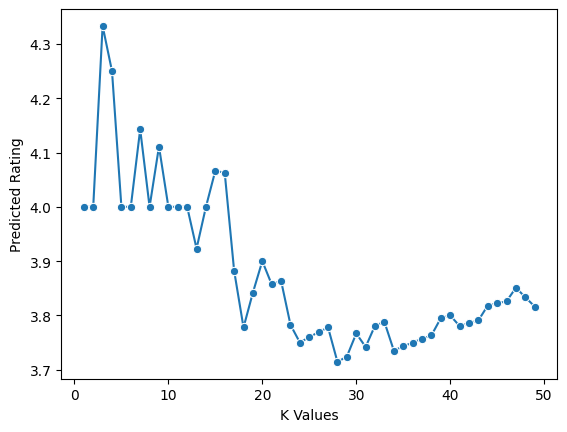

In [ ]:
# Create the KNN model - sci-kit learn makes iterating very easy
# KNeighborsRegressor uses the neighbors' average

k_values = [i for i in range (1,50)]
predictions = []

for k in k_values:
  users_knn_model = KNeighborsRegressor(metric='cosine', n_neighbors=k)

  # Fit the model using training data
  users_knn_model.fit(training_data_x, training_data_y)

  # Make prediction using the test data
  prediction = users_knn_model.predict(test_user_x)
  predictions.append(prediction[0])

# Plot the predictions
sns.lineplot(x = k_values, y = predictions, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Predicted Rating")

We can see in the graph above that as k increases, the predicted rating decreases and starts to hover around 3.8 around k=25.

Text(0, 0.5, 'Predicted Rating')

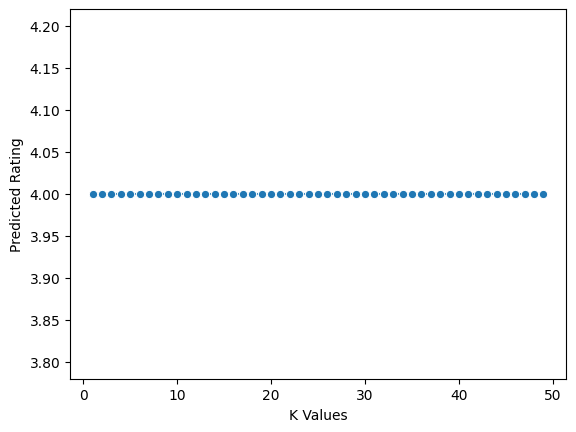

In [ ]:
# Create the KNN model
# KNeighborsClassifier finds the most common neighbors' rating

k_values = [i for i in range (1,50)]
predictions = []

for k in k_values:
  users_knn_model_classifier = KNeighborsClassifier(metric='cosine', n_neighbors=k)

  # Fit the model using training data
  users_knn_model_classifier.fit(training_data_x, training_data_y)

  # Make prediction using the test data
  prediction = users_knn_model_classifier.predict(test_user_x)
  predictions.append(prediction[0])

# Plot the predictions
sns.lineplot(x = k_values, y = predictions, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Predicted Rating")

This graph shows that as the k value increases, the predicted rating remains at 4.

### Item-based

Now let's try item-based collaborative filtering. We'll first need to transpose the data so the movie titles are the index:

In [ ]:
# Transpose the data frame to make movies the index
movie_ratings = user_movie_ratings_normalized.T
movie_ratings.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1-900 (1994),0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),-1.605166,0.0,0.000000,0.0,-0.874286,0.000000,0.000000,0.0,0.0,0.000000,...,-1.696532,0.0,0.0,-1.358974,0.731481,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),1.394834,0.0,0.000000,0.0,0.000000,0.360577,0.037406,0.0,0.0,0.793478,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
187 (1997),0.000000,0.0,-0.773585,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


##### Finding Similarities

Cosine similarity:

In [ ]:
# Create the similarity matrix
movie_similarities = cosine_similarity(movie_ratings)

# Create data frame
cosine_sim_df = pd.DataFrame(movie_similarities, index=movie_ratings.index, columns=movie_ratings.index)
cosine_sim_df.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),1.000000,0.000000,0.049086,-0.068248,-0.003543,0.012290,0.000000,0.036219,0.000000,-0.025455,...,0.000000,0.000000,0.000000,-0.038064,-0.051581,0.027212,-0.119613,0.000000,0.098115,0.000000
1-900 (1994),0.000000,1.000000,-0.053482,-0.073019,0.030803,0.025685,-0.022816,-0.141149,0.000000,0.000000,...,0.693593,0.066033,0.000000,-0.182013,-0.179709,-0.111674,0.027780,-0.175940,0.037118,0.000000
101 Dalmatians (1996),0.049086,-0.053482,1.000000,-0.188426,0.042000,0.065134,0.098269,-0.131197,0.046325,-0.103977,...,0.000000,0.013024,-0.171204,-0.135849,-0.008253,0.101647,-0.007123,0.120960,-0.047336,0.000000
12 Angry Men (1957),-0.068248,-0.073019,-0.188426,1.000000,-0.056615,-0.022323,-0.009899,0.152949,-0.084074,0.288243,...,-0.105277,-0.029077,0.000000,0.165062,-0.026772,-0.132707,-0.018477,-0.006453,0.018922,0.098965
187 (1997),-0.003543,0.030803,0.042000,-0.056615,1.000000,-0.003623,-0.006598,-0.043091,0.057056,-0.007438,...,0.000000,0.071296,0.000000,-0.015888,-0.015154,0.010546,0.010201,-0.032097,0.007872,-0.137136


We now have a similarities data frame of movie titles.

##### Testing

Let's test for the movie `Toy Story (1995)`:

In [ ]:
display("--- Testing 'Toy Story (1995)' ---")
display("\n[Cosine Similarity Item-Based Recommendations]")

# Grab the similarities for a movie
cosine_similarity_series = cosine_sim_df.loc['Toy Story (1995)']

# Sort similarities
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

display(ordered_similarities.head())

"--- Testing 'Toy Story (1995)' ---"

'\n[Cosine Similarity Item-Based Recommendations]'

,Toy Story (1995)
title,
Toy Story (1995),1.000000
Raiders of the Lost Ark (1981),0.271266
Beauty and the Beast (1991),0.240566
Star Wars (1977),0.235199
Apollo 13 (1995),0.229321


We can see that `Raiders of the Lost Ark (1981)`, `Beauty and the Beast (1991)`, `Star Wars (1977)` and `Apollo 13 (1995)` are the most similar movies. This makes sense since all of these movies could be considered classics, similar to `Toy Story`.

##### K-nearest neighbors

Now let's try a KNN model for item-based collaborative filtering, and try to predict user `8`'s rating for `Toy Story (1995)`:

In [ ]:
# Predict Toy Story rating for user 8
movie_ratings_copy = movie_ratings.copy()
movie_ratings_copy.drop(1, axis=1, inplace=True)

# Grab the test data x
test_movie_x = movie_ratings_copy.loc[["Toy Story (1995)"]]

# Grab the training target data (user's data)
training_data_y_movies = user_movie_ratings_pivot.T[8]

# Grab the users who have seen the movie
training_data_x_movies = movie_ratings_copy[training_data_y_movies.notnull()]

# Only focus on users who have seen the movie
training_data_y_movies.dropna(inplace=True)

# Create the KNN model
# KNeighborsRegressor uses the neighbors' average
movies_knn_model = KNeighborsRegressor(metric='cosine', n_neighbors=10)

# Fit the model using training data
movies_knn_model.fit(training_data_x_movies, training_data_y_movies)

# Make prediction using the test data
prediction_item_based = movies_knn_model.predict(test_movie_x)
display("The item-item KNN model predicted {}".format(prediction_item_based[0]))

'The item-item KNN model predicted 4.5'

The item-item based KNN model predicted 4.5, which is slightly higher than the user-user model prediction of 4.

## Quantitative Evaluation (RMSE)

Right now, we're just doing qualitive analysis of the results. To properly measure our model's performance, we need a quantitative metric. We will use Root Mean Squared Error (RMSE), which tells us, on average, how far off our predicted ratings are from the actual ratings. A lower RMSE is better.

 To do this, we will:
 1.  Split our known ratings into a `training set` and a `testing set`.
 2.  Build the user-item matrix using **only** the training set.
 3.  Apply regularization to the user averages before normalizing the data.
 4.  Loop through the test set to predict ratings and calculate the final RMSE.

# 1. Split the data

We'll use an 80/20 split. `random_state` ensures we get the same split every time.

In [ ]:
train_df, test_df = train_test_split(user_movie_ratings, test_size=0.2, random_state=42)

display(f"Training set size: {len(train_df)}")
display(f"Testing set size: {len(test_df)}")

'Training set size: 79791'

'Testing set size: 19948'

# 2. Build User-Item Matrix on Training Data ONLY

In [ ]:
train_pivot = train_df.pivot_table(index="user_id",
                                   columns="title",
                                   values="rating",
                                   aggfunc="mean"
                                )
train_avg_ratings  = train_pivot.mean(axis=1)
train_centered  = train_pivot.sub(train_avg_ratings, axis=0)
train_normalized = train_centered.fillna(0)

# 3. Loop, predict, and evaluate

 For demonstration, we'll run on a sample of 100 ratings from the test set.
Remove `.sample(100, random_state=42)` to run on the full test set (will be very slow).

In [ ]:
user_similarity = cosine_similarity(train_normalized)
user_sim_df = pd.DataFrame(user_similarity, index=train_normalized.index, columns=train_normalized.index)

true_ratings = []
predicted_ratings = []

Here we prepare data for that specific movie (these are the steps that the KNN model performs):

In [ ]:
test_sample = test_df.sample(100, random_state=42)


for _,  row in test_sample.iterrows():
    user_id = row['user_id']
    movie_title = row['title']
    actual_rating = row['rating']

    # Make sure the user and movie exist in our training matrix
    if user_id not in train_normalized.index or movie_title not in train_normalized.columns:
        continue

    # 1. Identify Similar Users
    # Find the top 10 most similar users to our target user (excluding the user themselves)
    n = 10
    similar_users = user_sim_df[user_id].sort_values(ascending=False).iloc[1:n+1]

    # If no similar users found, we can't predict
    if similar_users.empty:
        continue

    # 2. Filter for Relevant Ratings
    # Find which of these similar users have actually rated the target movie
    neighbor_ratings = train_pivot.loc[similar_users.index, movie_title].dropna()

    # If none of the neighbors have rated the movie, we can't predict
    if neighbor_ratings.empty:
        continue

    # 3. & 4. We will calculate the weighted average.
    # The "weight" is the similarity score of the neighbor.
    # Get the similarity scores for just the neighbors who rated the movie
    neighbor_similarities = user_sim_df.loc[neighbor_ratings.index, user_id]

    # Calculate the weighted average of the neighbors' ratings
    # (sum of (similarity * rating)) / (sum of similarities)
    numerator = np.dot(neighbor_ratings, neighbor_similarities)
    denominator = neighbor_similarities.sum()

    if denominator == 0:
        continue # Avoid division by zero

    predicted_rating = numerator / denominator

    predicted_ratings.append(predicted_rating)
    true_ratings.append(actual_rating)


In [ ]:
if len(true_ratings) > 0:
    global_rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    display(f"\n--- Global Model Performance (with Regularization) ---")
    display(f"Global Root Mean Squared Error (RMSE): {global_rmse:.4f}")
    display(f"Evaluated on {len(true_ratings)} ratings from the test set sample.")
else:
    display("\nCould not find any evaluatable ratings in the test set sample.")

'\n--- Global Model Performance (with Regularization) ---'

'Global Root Mean Squared Error (RMSE): 1.1001'

'Evaluated on 82 ratings from the test set sample.'

Now let's test out different values for number of neighbors to look at:

In [ ]:
# Test out the model with different number of neighbors
test_sample = test_df.sample(100, random_state=42)

neighbors = [i for i in range (1,50)]
predictions = []
rmse_values = []

for neighbor in neighbors:
  true_ratings = []
  predicted_ratings = []
  for _,  row in test_sample.iterrows():
      user_id = row['user_id']
      movie_title = row['title']
      actual_rating = row['rating']

      # Make sure the user and movie exist in our training matrix
      if user_id not in train_normalized.index or movie_title not in train_normalized.columns:
          continue

      # 1. Identify Similar Users
      # Find the top 10 most similar users to our target user (excluding the user themselves)
      n = neighbor
      similar_users = user_sim_df[user_id].sort_values(ascending=False).iloc[1:n+1]

      # If no similar users found, we can't predict
      if similar_users.empty:
          continue

      # 2. Filter for Relevant Ratings
      # Find which of these similar users have actually rated the target movie
      neighbor_ratings = train_pivot.loc[similar_users.index, movie_title].dropna()

      # If none of the neighbors have rated the movie, we can't predict
      if neighbor_ratings.empty:
          continue

      # 3. & 4. We will calculate the weighted average.
      # The "weight" is the similarity score of the neighbor.
      # Get the similarity scores for just the neighbors who rated the movie
      neighbor_similarities = user_sim_df.loc[neighbor_ratings.index, user_id]

      # Calculate the weighted average of the neighbors' ratings
      # (sum of (similarity * rating)) / (sum of similarities)
      numerator = np.dot(neighbor_ratings, neighbor_similarities)
      denominator = neighbor_similarities.sum()

      if denominator == 0:
          continue # Avoid division by zero

      predicted_rating = numerator / denominator

      predicted_ratings.append(predicted_rating)
      true_ratings.append(actual_rating)

  # Find the RMSE
  if len(true_ratings) > 0:
    global_rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    rmse_values.append(global_rmse)

Now let's plot the RMSE graph:

'Best number of neighbors value: 47'

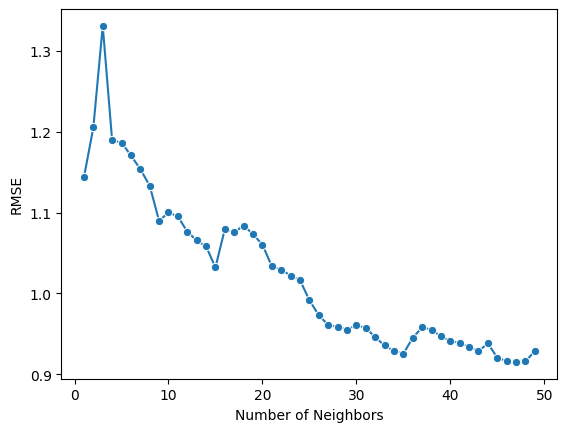

In [ ]:
# Plot the rmse graph
sns.lineplot(x = neighbors, y = rmse_values, marker = 'o')
plt.xlabel("Number of Neighbors")
plt.ylabel("RMSE")

display(f"Best number of neighbors value: {neighbors[np.argmin(rmse_values)]}")

As we can see from the graph and our code, the best amount of neighbors to produce the lowest RMSE is 47.

## Critique and Further Thought:
 An RMSE of 1.1 is a respectable baseline, but there is ample room for improvement. We could explore more advanced techniques like Singular Value Decomposition (SVD) or even deep learning models to capture more complex relationships in the data.

# Conclusion
In this project we systematically explored the development of a recommendation system, from simple content-based models to more complex collaborative filtering techniques. We've seen how data enrichment and feature weighting can enhance a model's performance and how quantitative metrics like RMSE are essential for objective evaluation and optimization.

### Future Directions:

**Hybrid Approaches**: Combining content-based and collaborative filtering methods could mitigate the "cold start" problem and yield more robust recommendations.

**Advanced Matrix Factorization**: Techniques like SVD can more effectively handle the sparsity of the user-item matrix. ALS via Spark would also be a good approach to look into.

**Deep Learning**: Neural collaborative filtering and other deep learning models could be employed to learn more complex, non-linear relationships within the data.